In [1]:
from google.colab import drive
drive.mount('/content/drive')
from pathlib import Path
import os
repo_path = Path.cwd()/'drive/MyDrive/calcification_detection/calc-det/notebooks/'
os.chdir(str(repo_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !mkdir '/home/INbreast Release 1.0/'
# !mkdir '/home/INbreast Release 1.0/AllPNGs/'
# !mkdir '/home/INbreast Release 1.0/AllMasks/'
# !rsync -rva '/content/drive/MyDrive/calcification_detection/calc-det/data/INbreast Release 1.0/AllPNGs/full_imgs' '/home/INbreast Release 1.0/AllPNGs/'
# !rsync -rva '/content/drive/MyDrive/calcification_detection/calc-det/data/INbreast Release 1.0/images_metadata.csv' '/home/INbreast Release 1.0/images_metadata.csv'
# !rsync -rva '/content/drive/MyDrive/calcification_detection/calc-det/data/INbreast Release 1.0/rois_metadata.csv' '/home/INbreast Release 1.0/rois_metadata.csv'
# !rsync -rva '/content/drive/MyDrive/calcification_detection/calc-det/data/INbreast Release 1.0/AllMasks/full_imgs' '/home/INbreast Release 1.0/AllMasks/'
# !rsync -rva '/content/drive/MyDrive/calcification_detection/data/deepl_runs' '/home/'

In [4]:
from pathlib import Path
thispath = Path.cwd().resolve()
import sys; sys.path.insert(0, str(thispath.parent))
from database.dataset import INBreast_Dataset

db = INBreast_Dataset(
    imgpath = Path('/home/INbreast Release 1.0/AllPNGs'),
    mask_path = Path('/home/INbreast Release 1.0/AllMasks'),
    dfpath = Path('/home/INbreast Release 1.0'),
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions = ['validation'],
    lesion_types = ['calcification', 'cluster'],
    cropped_imgs = True,
    keep_just_images_of_lesion_type = False,
    use_muscle_mask=False,
    ignore_diameter_px = 15
  )

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


# 32 X 32 Patches using ResnetBased, 32_net2_05


In [12]:
import pickle
import time
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

from metrics.metrics_utils import get_froc_df_of_img, get_tp_fp_fn_center_patch_criteria
from deep_learning.dl_utils import get_model_from_checkpoint
from deep_learning.models.class_based_detector import ClassificationBasedDetector


# model
model_path = '/home/deepl_runs/32_net2_05/32_net2_05_auroc.pt'
model_ckpt = torch.load(model_path)
model = get_model_from_checkpoint(model_ckpt, freezed=)

# detector instatiation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
detector = ClassificationBasedDetector(
    model,
    threshold=0,
    pred_kind='score',
    norm_kind='avg',
    post_proc=True,
    k_size=17,
    patch_size=32,
    stride=8,
    min_breast_fraction_patch=0.7,
    batch_size=1024,
    device=device,
    nms=True,
    iou_threshold=1)

# get detections
normal_imgs_ids = db.get_free_of_selected_lesions_imgs_ids()

results_path = Path('/content/drive/MyDrive/calcification_detection/detections_dl/32_net2_05')
frocs_df_path = results_path / 'froc_df.csv'
times_path = results_path / 'times.p'
froc_dfs = []
times = []
for idx in range(len(db)):
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db_sample['img_id']
    image_mask = db_sample['lesion_mask']

    results_path_img = results_path / f'{image_id}'
    results_path_img.mkdir(exist_ok=True, parents=True)
    raw_saliency_path = results_path_img / f'{image_id}_raw_sm.tiff'
    final_saliency_path = results_path_img / f'{image_id}_final_sm.tiff'
    froc_df_path = results_path_img / f'{image_id}_froc_df.csv'
    # get detections:
    start = time.time()
    detections = detector.detect(image, raw_saliency_path, final_saliency_path)
    times.append(time.time()-start)

    detections_centers = detections[:, 0:2].astype(int)
    detections_scores = detections[:, -1].reshape(-1, 1)
    detections_radius = np.ones(detections_scores.shape) * 7

    # retain the centers and scores:
    candidates = np.concatenate([detections_centers, detections_radius, detections_scores], axis = 1)

    # compare with labels
    tp, fp, fn, ignored_candidates = get_tp_fp_fn_center_patch_criteria(
        candidates, image_mask, None, 14, use_euclidean_dist=True, scores_passed=True)

    # compare with labels
    candidates = pd.concat([tp, fp], axis=0, ignore_index=True)
    labels = np.where(candidates.label.values == 'TP', True, False)

    # Restore repeted detections and generate standar dataframe
    froc_df = get_froc_df_of_img(candidates
                                , fn, candidates['score'], image_id, (image_id in normal_imgs_ids))
    froc_df.to_csv(froc_df_path)
    froc_dfs.append(froc_df)
froc_dfs = pd.concat(froc_dfs, ignore_index=True)
froc_dfs.to_csv(froc_df_path)
# with open(times_path, 'wb') as f:
#     pickle.dump(times, f)

 14%|█▍        | 7/50 [00:04<00:24,  1.74it/s]


KeyboardInterrupt: ignored

In [10]:
# 20
froc_dfs.label.value_counts()

FP    181999
FN       353
TP       285
Name: label, dtype: int64

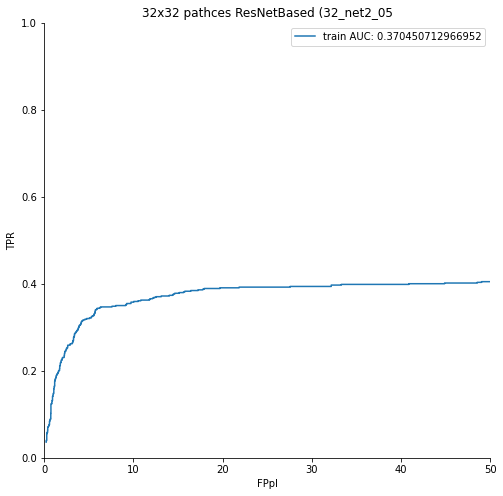

In [11]:
from general_utils.plots import plot_froc
from metrics.metrics import froc_curve

sens, avgs_fp_per_image, _ = froc_curve(froc_dfs, non_max_supression=True, cut_on_50fpi=True)
plot_froc(avgs_fp_per_image, sens, label='train', title='32x32 pathces ResNetBased (32_net2_05')

In [8]:
# 20
froc_dfs.label.value_counts()

FP    91721
FN      326
TP      299
Name: label, dtype: int64

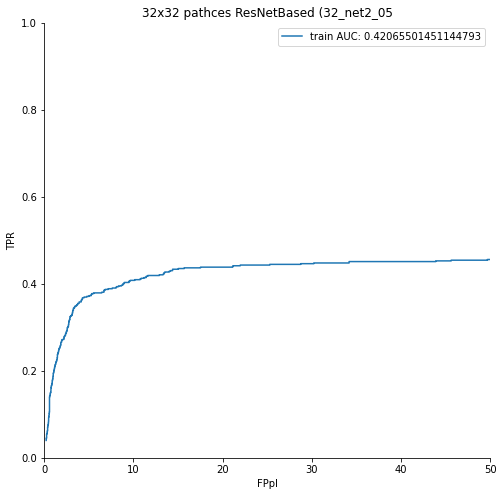

In [10]:
from general_utils.plots import plot_froc
from metrics.metrics import froc_curve

sens, avgs_fp_per_image, _ = froc_curve(froc_dfs, non_max_supression=True, cut_on_50fpi=True)
plot_froc(avgs_fp_per_image, sens, label='train', title='32x32 pathces ResNetBased (32_net2_05')

# 16 X 16 Patches using ResnetBased, 16_net2_07

In [11]:
!rsync -rva '/content/drive/MyDrive/drive_unicas/deepl_runs' '/home/dl_runs_unicas'

sending incremental file list
deepl_runs -> /content/drive/.shortcut-targets-by-id/1FoOxzgYyiAszhqGQEbCttrh-Z0GZFq1z/deepl_runs

sent 134 bytes  received 19 bytes  306.00 bytes/sec
total size is 0  speedup is 0.00


In [13]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.2 MB/s 
     |████████████████████████████████| 596 kB 72.0 MB/s 
     |████████████████████████████████| 86 kB 6.6 MB/s 
     |████████████████████████████████| 6.6 MB 67.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [15]:
import pickle
import time
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

from metrics.metrics_utils import get_froc_df_of_img, get_tp_fp_fn_center_patch_criteria
from deep_learning.dl_utils import get_model_from_checkpoint
from deep_learning.models.class_based_detector import ClassificationBasedDetector


# model
model_path = '/home/dl_runs_unicas/16_net2_07/16_net2_07_auroc.pt'
model_ckpt = torch.load(model_path)
model = get_model_from_checkpoint(model_ckpt)

# detector instatiation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
detector = ClassificationBasedDetector(
    model,
    threshold=0,
    pred_kind='score',
    norm_kind='avg',
    post_proc=True,
    k_size=9,
    patch_size=16,
    stride=8,
    min_breast_fraction_patch=0.7,
    batch_size=2048,
    device=device,
    nms=True,
    iou_threshold=1)

# get detections
normal_imgs_ids = db.get_free_of_selected_lesions_imgs_ids()

results_path = Path('/content/drive/MyDrive/calcification_detection/detections_dl/16_net2_07')
frocs_df_path = results_path / 'froc_df.csv'
times_path = results_path / 'times.p'
froc_dfs = []
times = []
for idx in range(len(db)):
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db_sample['img_id']
    image_mask = db_sample['lesion_mask']

    results_path_img = results_path / f'{image_id}'
    results_path_img.mkdir(exist_ok=True, parents=True)
    raw_saliency_path = results_path_img / f'{image_id}_raw_sm.tiff'
    final_saliency_path = results_path_img / f'{image_id}_final_sm.tiff'
    froc_df_path = results_path_img / f'{image_id}_froc_df.csv'
    # get detections:
    start = time.time()
    detections = detector.detect(image, raw_saliency_path, final_saliency_path)
    times.append(time.time()-start)

    detections_centers = detections[:, 0:2].astype(int)
    detections_scores = detections[:, -1].reshape(-1, 1)
    detections_radius = np.ones(detections_scores.shape) * 7

    # retain the centers and scores:
    candidates = np.concatenate([detections_centers, detections_radius, detections_scores], axis = 1)

    # compare with labels
    tp, fp, fn, ignored_candidates = get_tp_fp_fn_center_patch_criteria(
        candidates, image_mask, None, 14, use_euclidean_dist=True, scores_passed=True)

    # compare with labels
    candidates = pd.concat([tp, fp], axis=0, ignore_index=True)
    labels = np.where(candidates.label.values == 'TP', True, False)

    # Restore repeted detections and generate standar dataframe
    froc_df = get_froc_df_of_img(candidates
                                , fn, candidates['score'], image_id, (image_id in normal_imgs_ids))
    froc_df.to_csv(froc_df_path)
    froc_dfs.append(froc_df)
froc_dfs = pd.concat(froc_dfs, ignore_index=True)
froc_dfs.to_csv(froc_df_path)
with open(times_path, 'wb') as f:
    pickle.dump(times, f)

100%|██████████| 31/31 [00:07<00:00,  4.03it/s]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
100%|██████████| 33/33 [00:08<00:00,  3.97it/s]


TypeError: ignored

In [17]:
times_path = results_path / 'times.p'
with open(times_path, 'wb') as f:
    pickle.dump(times, f)

In [18]:
# 20
froc_dfs.label.value_counts()

FP    224715
TP       423
FN       211
Name: label, dtype: int64

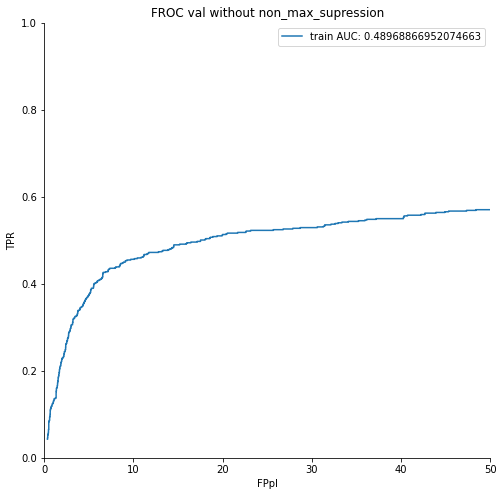

In [19]:
from general_utils.plots import plot_froc
from metrics.metrics import froc_curve

sens, avgs_fp_per_image, _ = froc_curve(froc_dfs, non_max_supression=True, cut_on_50fpi=True)
plot_froc(avgs_fp_per_image, sens, label='train', title='FROC val without non_max_supression')

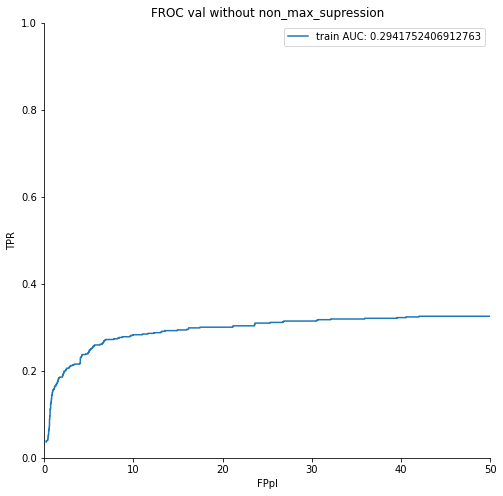

In [ ]:
from general_utils.plots import plot_froc
from metrics.metrics import froc_curve

sens, avgs_fp_per_image, _ = froc_curve(froc_dfs, non_max_supression=True, cut_on_50fpi=True)
plot_froc(avgs_fp_per_image, sens, label='train', title='FROC val without non_max_supression')

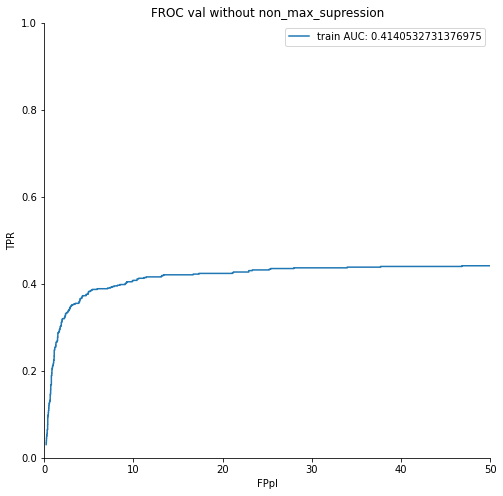

In [ ]:
from general_utils.plots import plot_froc
from metrics.metrics import froc_curve

sens, avgs_fp_per_image, _ = froc_curve(froc_dfs, non_max_supression=True, cut_on_50fpi=True)
plot_froc(avgs_fp_per_image, sens, label='train', title='FROC val without non_max_supression')

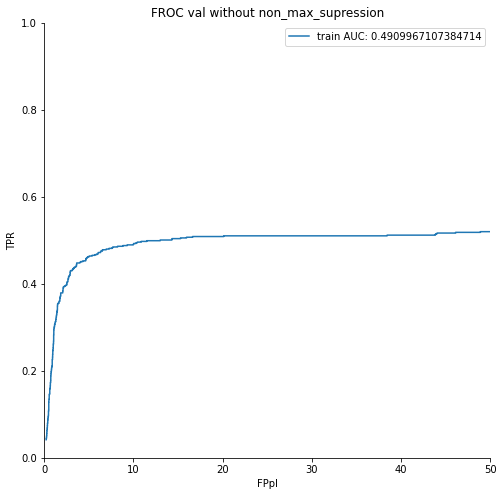

In [ ]:
from general_utils.plots import plot_froc
from metrics.metrics import froc_curve

sens, avgs_fp_per_image, _ = froc_curve(froc_dfs, non_max_supression=True, cut_on_50fpi=True)
plot_froc(avgs_fp_per_image, sens, label='train', title='FROC val without non_max_supression')

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(45, 45))
# plot_detections(detections[:, 2:], image, k=0, gt_bboxes=db_sample['lesion_bboxes'], ax=ax[0])
# ax[0].set_title('used_gt')
# plot_detections(detections[:, 2:], image, k=0, gt_bboxes=db_sample['ignored_lesion_bboxes'], ax=ax[1])
# ax[1].set_title('ignored_gt')
# plt.show()

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(45, 45))
# plot_detections(detections[:, 2:], detector.saliency_map, k=0, gt_bboxes=db_sample['lesion_bboxes'], ax=ax[0])
# ax[0].set_title('used_gt')
# plot_detections(detections[:, 2:], detector.saliency_map, k=0, gt_bboxes=db_sample['ignored_lesion_bboxes'], ax=ax[1])
# ax[1].set_title('ignored_gt')
# plt.show()

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(45, 45))
# plot_detections(detections[:, 2:], detector.saliency_map, k=0, gt_bboxes=db_sample['lesion_bboxes'], ax=ax[0])
# ax[0].set_title('used_gt')
# plot_detections(detections[:, 2:], detector.saliency_map, k=0, gt_bboxes=db_sample['ignored_lesion_bboxes'], ax=ax[1])
# ax[1].set_title('ignored_gt')
# plt.show()

In [ ]:
!rsync -rva '/content/drive/MyDrive/drive_unicas/deepl_runs' '/home/dl_runs_unicas'

sending incremental file list
deepl_runs -> /content/drive/.shortcut-targets-by-id/1FoOxzgYyiAszhqGQEbCttrh-Z0GZFq1z/deepl_runs

sent 134 bytes  received 19 bytes  306.00 bytes/sec
total size is 0  speedup is 0.00


In [ ]:
from tqdm import tqdm
from metrics.metrics_utils import get_froc_df_of_img, get_tp_fp_fn_center_patch_criteria
import pandas as pd


# model
model_path = '/home/dl_runs_unicas/16_net2_03/16_net2_03_auroc.pt'
model_ckpt = torch.load(model_path)
model = get_model(model_ckpt)

# detector instatiation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
detector = ClassificationBasedDetector(
    model,
    threshold=0,
    pred_kind='score',
    norm_kind='avg',
    post_proc=True,
    k_size=9,
    patch_size=16,
    stride=8,
    min_breast_fraction_patch=0.7,
    batch_size=2048,
    device=device,
    nms=True,
    iou_threshold=1)

# get detections
normal_imgs_ids = db.get_free_of_selected_lesions_imgs_ids()

results_path = Path('/content/drive/MyDrive/calcification_detection/detections_dl/16_net2_03')
frocs_df_path = results_path / 'froc_df.csv'
froc_dfs = []

for idx in range(len(db)):
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db_sample['img_id']
    image_mask = db_sample['lesion_mask']

    results_path_img = results_path / f'{image_id}'
    results_path_img.mkdir(exist_ok=True, parents=True)
    raw_saliency_path = results_path_img / f'{image_id}_raw_sm.tiff'
    final_saliency_path = results_path_img / f'{image_id}_final_sm.tiff'
    froc_df_path = results_path_img / f'{image_id}_froc_df.csv'
    # get detections:
    detections = detector.detect(image, raw_saliency_path, final_saliency_path)

    detections_centers = detections[:, 0:2].astype(int)
    detections_scores = detections[:, -1].reshape(-1, 1)
    detections_radius = np.ones(detections_scores.shape) * 7

    # retain the centers and scores:
    candidates = np.concatenate([detections_centers, detections_radius, detections_scores], axis = 1)

    # compare with labels
    tp, fp, fn, ignored_candidates = get_tp_fp_fn_center_patch_criteria(
        candidates, image_mask, None, 14, use_euclidean_dist=True, scores_passed=True)

    # compare with labels
    candidates = pd.concat([tp, fp], axis=0, ignore_index=True)
    labels = np.where(candidates.label.values == 'TP', True, False)

    # Restore repeted detections and generate standar dataframe
    froc_df = get_froc_df_of_img(candidates
                                 , fn, candidates['score'], image_id, (image_id in normal_imgs_ids))
    froc_df.to_csv(froc_df_path)
    froc_dfs.append(froc_df)
froc_dfs = pd.concat(froc_dfs, ignore_index=True)
froc_dfs.to_csv(froc_df_path)

100%|██████████| 31/31 [00:07<00:00,  3.91it/s]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
100%|██████████| 33/33 [00:08<00:00,  3.87it/s]


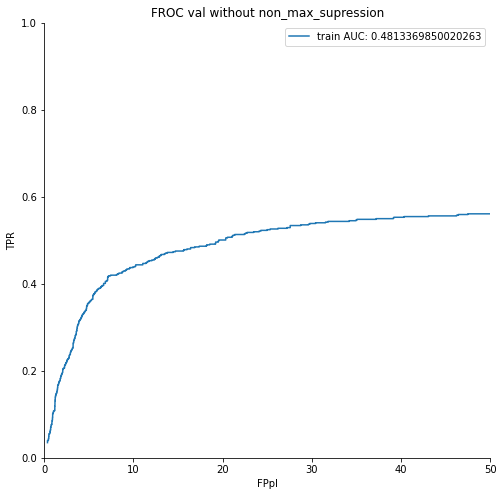

In [ ]:
from general_utils.plots import plot_froc
from metrics.metrics import froc_curve

sens, avgs_fp_per_image, _ = froc_curve(froc_dfs, non_max_supression=True, cut_on_50fpi=True)
plot_froc(avgs_fp_per_image, sens, label='train', title='FROC val without non_max_supression')

In [ ]:
detector = ClassificationBasedDetector(
    model,
    threshold=0.1,
    pred_kind='score',
    norm_kind='avg',
    post_proc=True,
    k_size=9,
    patch_size=16,
    stride=8,
    min_breast_fraction_patch=0.7,
    batch_size=2048,
    device=device,
    nms=True,
    iou_threshold=1)

idx=15

db_sample = db[idx]
image = db_sample['img']
image_id = db_sample['img_id']
image_mask = db_sample['lesion_mask']

results_path_img = results_path / f'{image_id}'
results_path_img.mkdir(exist_ok=True, parents=True)
raw_saliency_path = results_path_img / f'{image_id}_raw_sm.tiff'
final_saliency_path = results_path_img / f'{image_id}_final_sm.tiff'
froc_df_path = results_path_img / f'{image_id}_froc_df.csv'

# get detections:
detections = detector.detect(image, raw_saliency_path, final_saliency_path)

100%|██████████| 51/51 [00:13<00:00,  3.90it/s]


In [ ]:
image_id

22614150

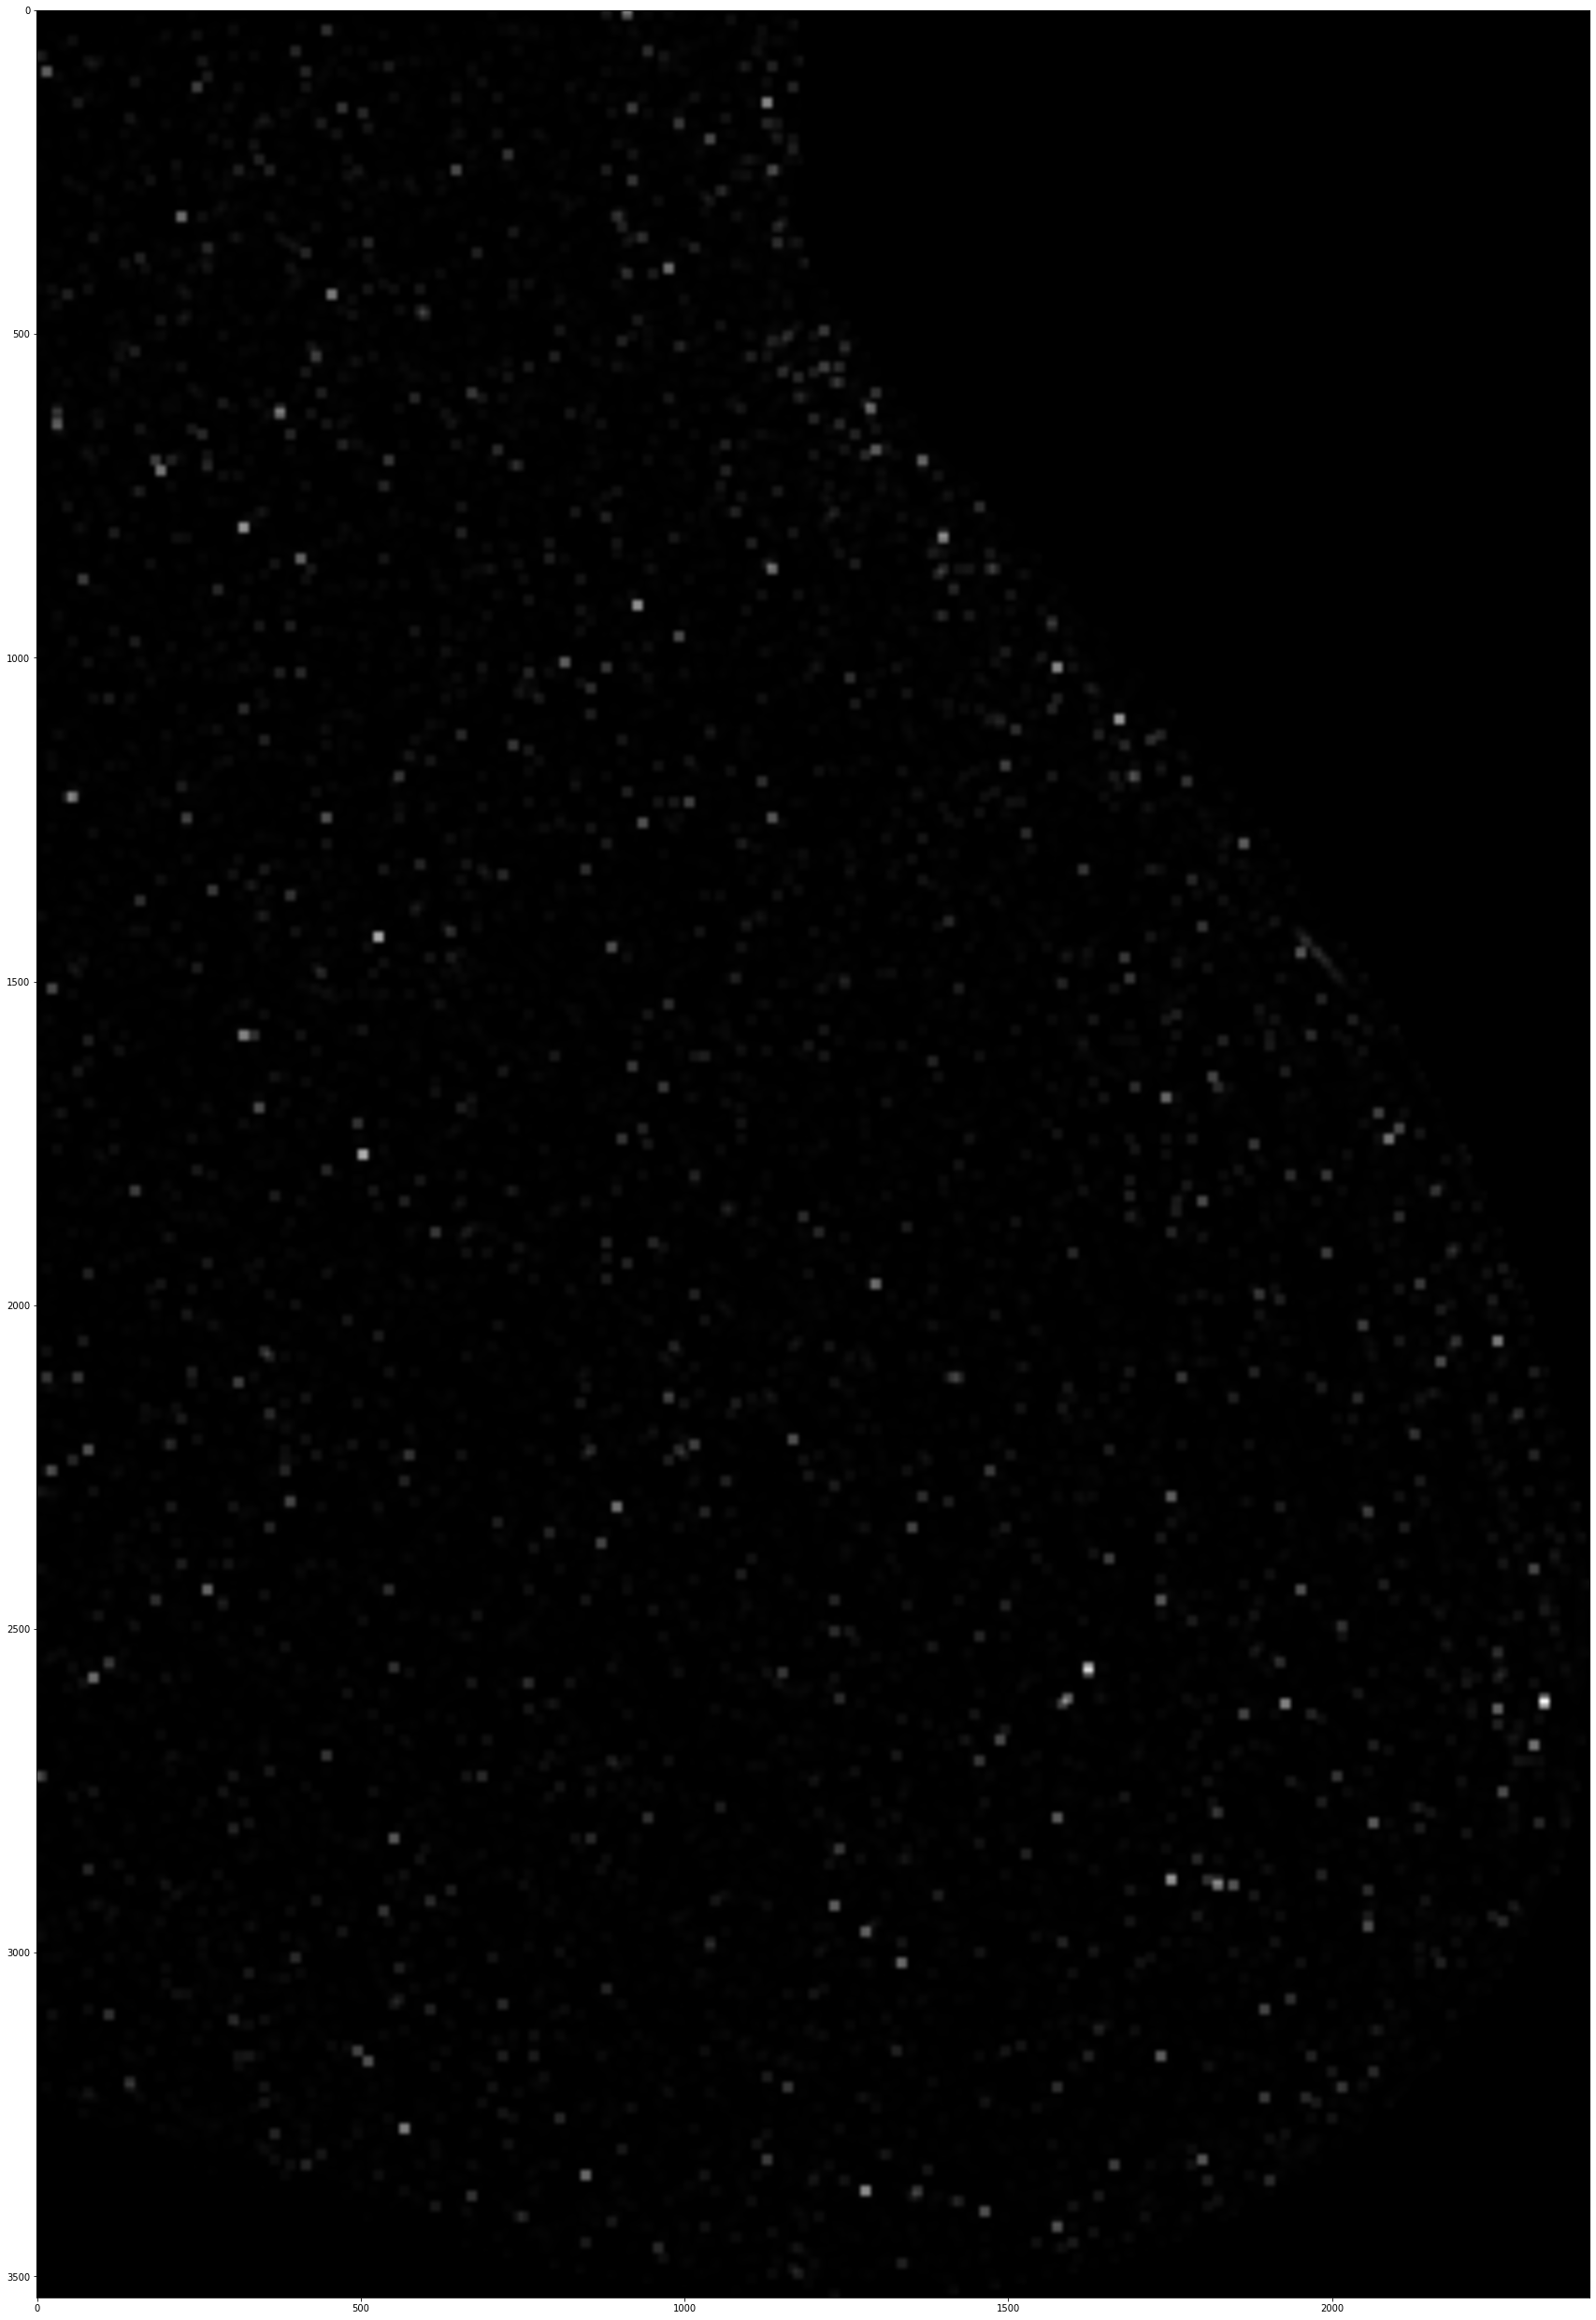

In [ ]:
plt.figure(figsize=(45, 45))
plt.imshow(detector.saliency_map, cmap='gray')

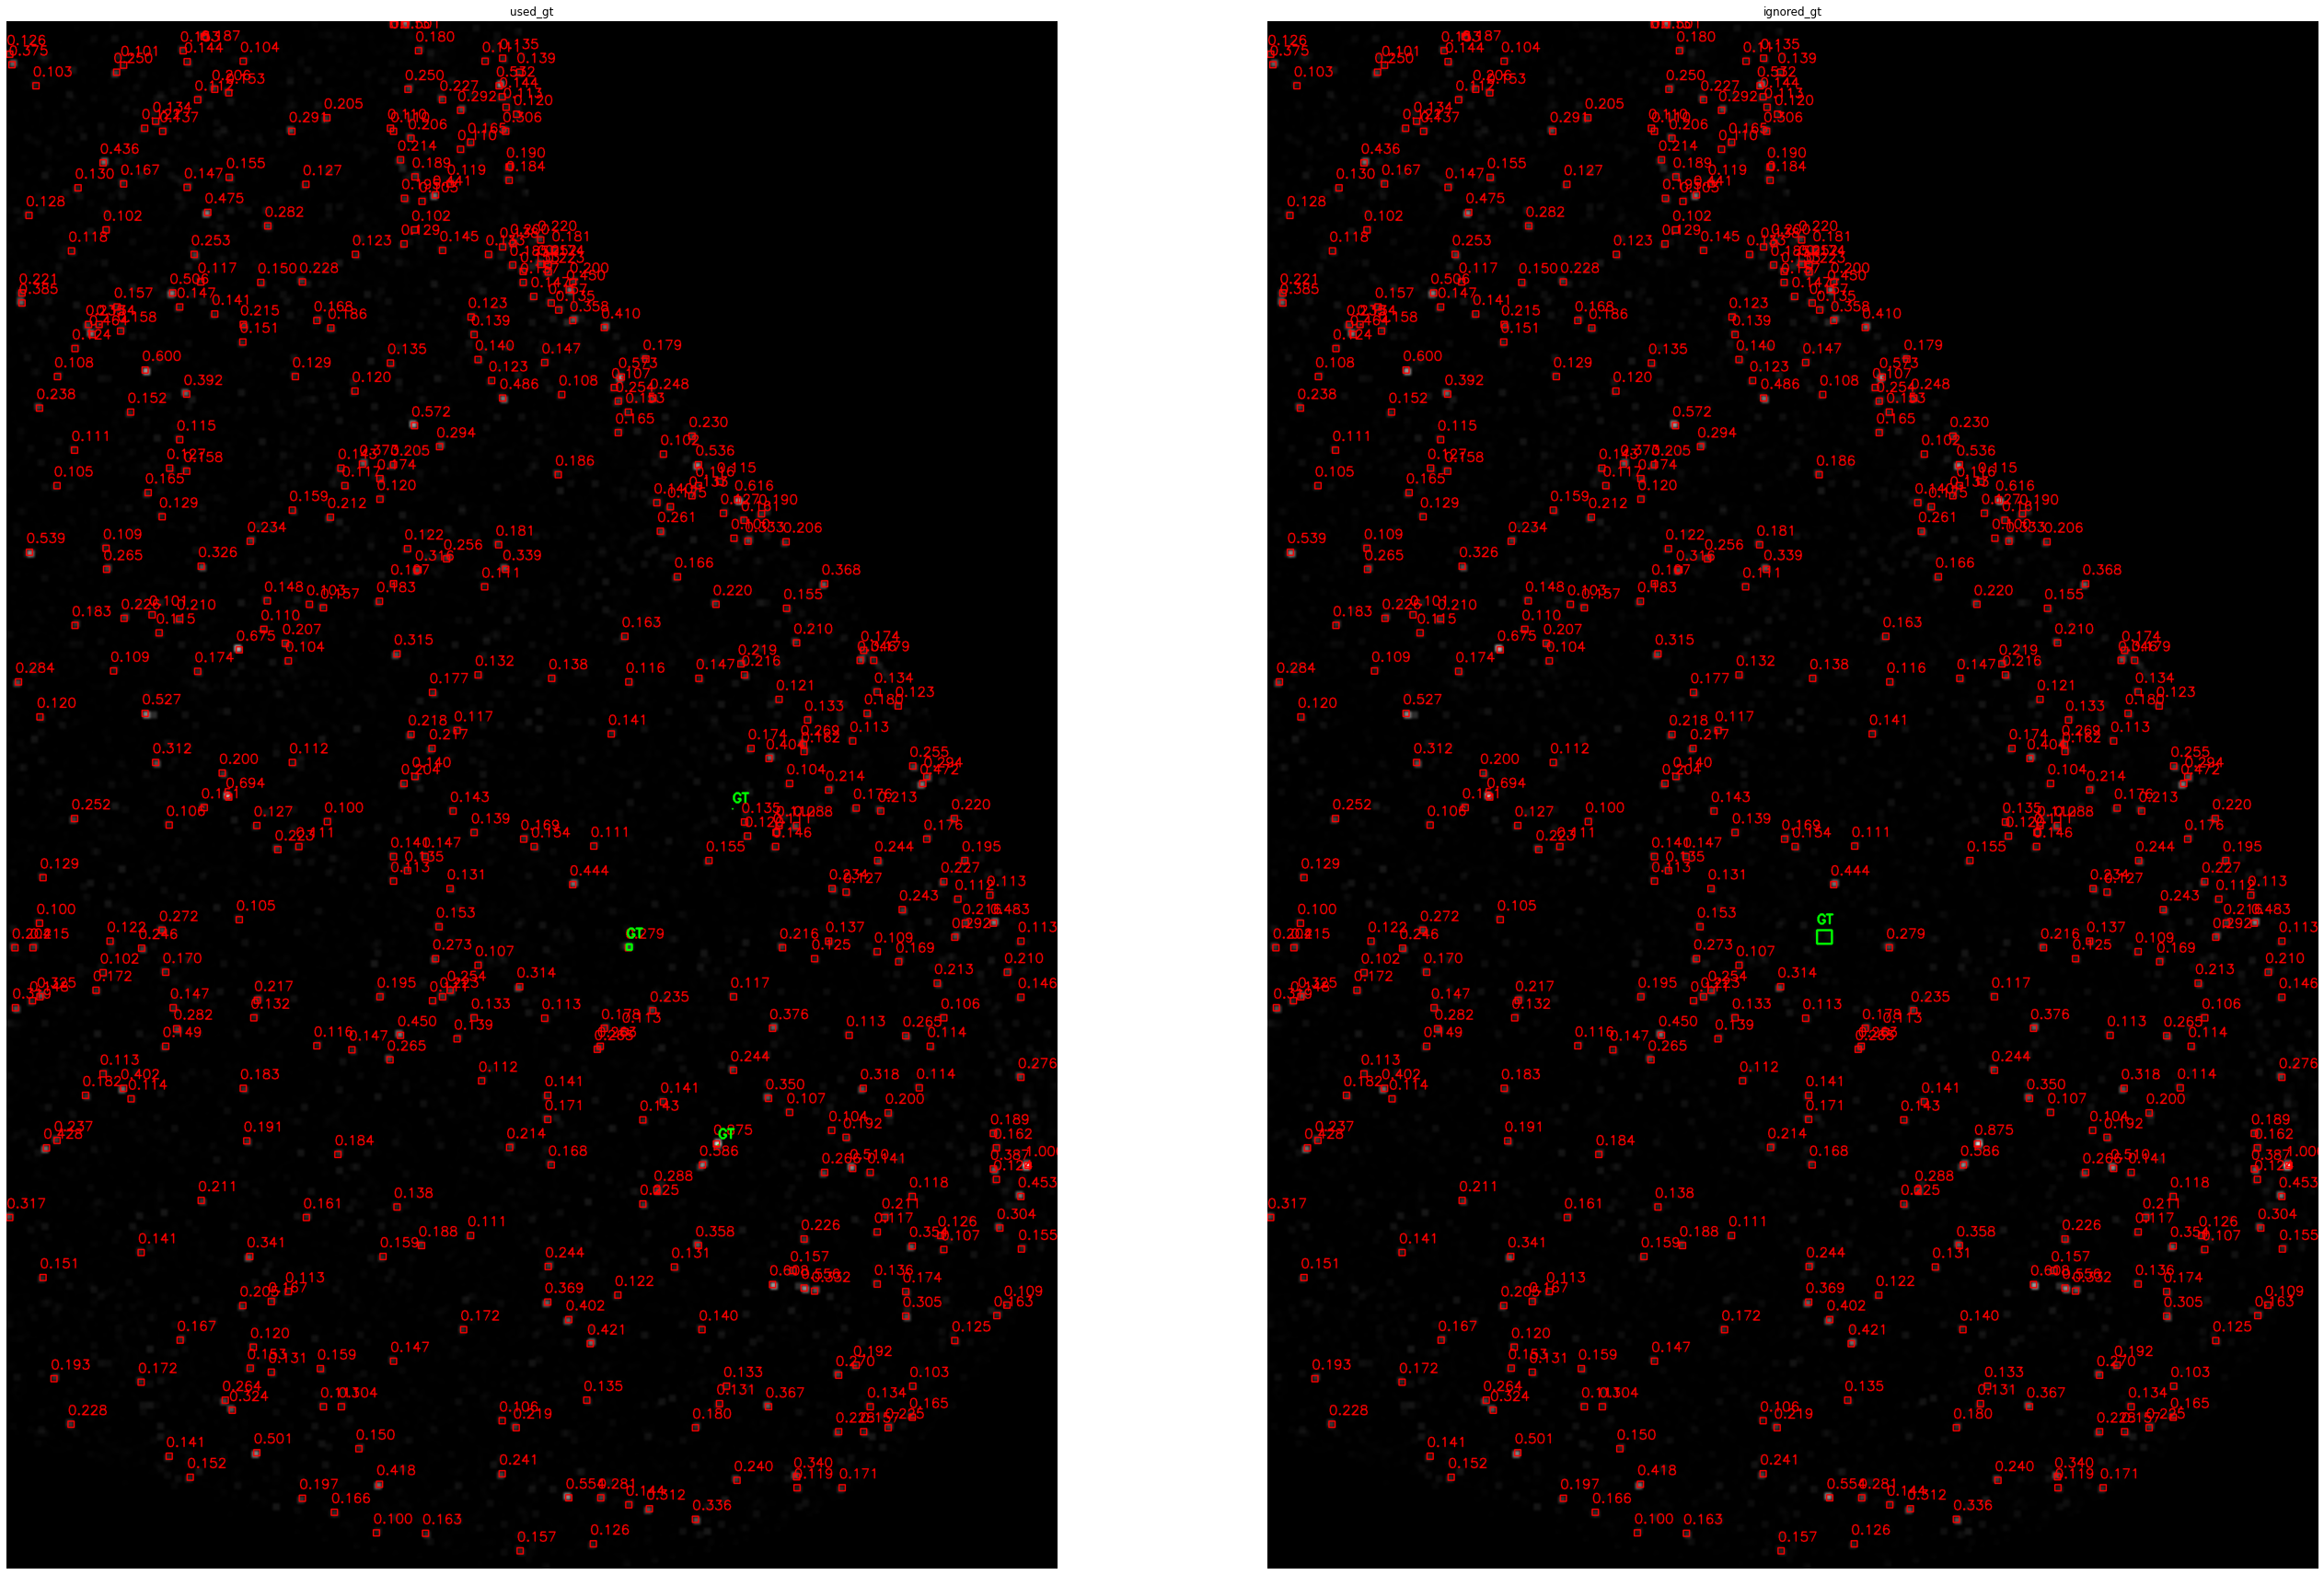

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(45, 45))
plot_detections(detections[:, 2:], detector.saliency_map, k=0, gt_bboxes=db_sample['lesion_bboxes'], ax=ax[0])
ax[0].set_title('used_gt')
plot_detections(detections[:, 2:], detector.saliency_map, k=0, gt_bboxes=db_sample['ignored_lesion_bboxes'], ax=ax[1])
ax[1].set_title('ignored_gt')
plt.show()